<a href="https://colab.research.google.com/github/ishan13b/Pytorch-Implementation/blob/main/DCGAN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install torch --upgrade --force-reinstall


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [2]:
# Root directory for dataset
datapath = "/content/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5


In [4]:
# First, install kaggle if not installed
!pip install kaggle

# Configure kaggle credentials
!mkdir -p ~/.kaggle
# Upload your kaggle.json file here

# Move kaggle.json to the right location
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
# Now download CelebA dataset
!kaggle datasets download jessicali9530/celeba-dataset

# Create directory
!mkdir celeba

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.32G/1.33G [00:17<00:00, 169MB/s]
100% 1.33G/1.33G [00:17<00:00, 80.2MB/s]


In [6]:

# Extract the dataset
!unzip celeba-dataset.zip -d celeba

Streaming output truncated to the last 5000 lines.
  inflating: celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197618.jpg  
  inflating

In [3]:
dataset = dset.ImageFolder(root = datapath,transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


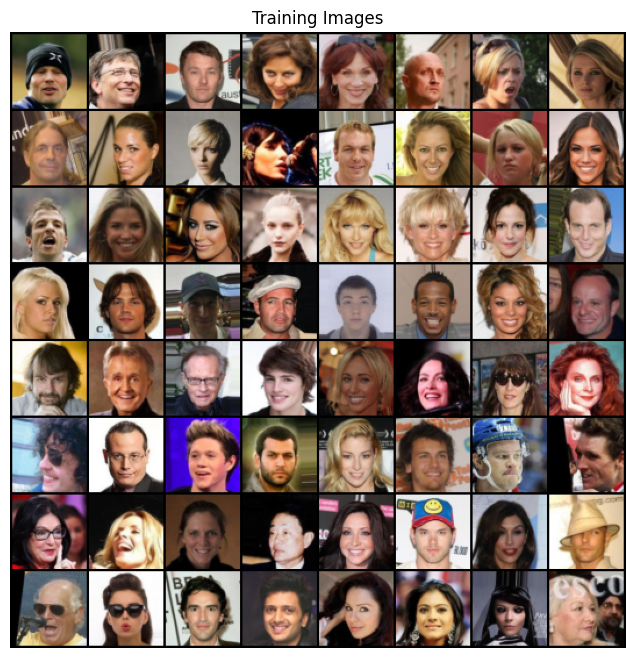

In [4]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [6]:
# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is ``(nc) x 64 x 64``
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf) x 32 x 32``
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*2) x 16 x 16``
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*4) x 8 x 8``
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*8) x 4 x 4``
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias = False)
    self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias = False)
    self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias = False)
    self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias = False)
    self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias = False)
    self.BatchNorm2d1 = nn.BatchNorm2d(ndf * 2)
    self.BatchNorm2d2 = nn.BatchNorm2d(ndf * 4)
    self.BatchNorm2d3 = nn.BatchNorm2d(ndf * 8)
    self.LeakyReLU = nn.LeakyReLU(0.2, inplace = True)
    self.Sigmoid = nn.Sigmoid()

  def forward(self, input):
    out = self.conv1(input)
    out = self.LeakyReLU(out)
    out = self.conv2(out)
    out = self.BatchNorm2d1(out)
    out = self.LeakyReLU(out)
    out = self.conv3(out)
    out = self.BatchNorm2d2(out)
    out = self.LeakyReLU(out)
    out = self.conv4(out)
    out = self.BatchNorm2d3(out)
    out = self.LeakyReLU(out)
    out = self.conv5(out)
    out = self.Sigmoid(out)
    return out



In [7]:
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (BatchNorm2d1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm2d2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm2d3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.2, inplace=True)
  (Sigmoid): Sigmoid()
)


In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

# class Generator(nn.Module):
#   def __init__(self):
#     super(Generator, self).__init__()
#     self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias = False)
#     self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias = False)
#     self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias = False)
#     self.conv4 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias = False)
#     self.conv5 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias = False)
#     self.BatchNorm2d1 = nn.BatchNorm2d(ngf * 8)
#     self.BatchNorm2d2 = nn.BatchNorm2d(ngf * 4)
#     self.BatchNorm2d3 = nn.BatchNorm2d(ngf * 2)
#     self.BatchNorm2d4 = nn.BatchNorm2d(ngf)
#     self.ReLU = nn.ReLU(True)
#     self.Tanh = nn.Tanh()

#   def forward(self, input):
#     out = self.conv1(input)
#     out = self.BatchNorm2d1(out)
#     out = self.ReLU(out)
#     out = self.conv2(out)
#     out = self.BatchNorm2d2(out)
#     out = self.ReLU(out)
#     out = self.conv3(out)
#     out = self.BatchNorm2d3(out)
#     out = self.ReLU(out)
#     out = self.conv4(out)
#     out = self.BatchNorm2d4(out)
#     out = self.ReLU(out)
#     out = self.conv5(out)
#     out = self.Tanh(out)
#     return out


In [9]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0


In [11]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
# Training Loop:

img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
  for i, data in enumerate(dataloader):

    # Train Discriminator:
    # With Real Batch
    netD.zero_grad()
    real = data[0].to(device)
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    output = netD(real).view(-1)

    real_err = criterion(output, label)
    real_err.backward()
    D_x = output.mean().item()

    # With Fake Batch
    noise = torch.randn(b_size, nz, 1 ,1, device = device)
    fake = netG(noise)
    label.fill_(fake_label)
    output = netD(fake.detach()).view(-1)

    fake_err = criterion(output, label)
    fake_err.backward()
    D_G_1 = output.mean().item()

    errD = real_err + fake_err
    optimizerD.step()

    # Train Generator:
    netG.zero_grad()
    label.fill_(real_label)
    output = netD(fake).view(-1)

    errG = criterion(output, label)
    errG.backward()
    D_G_2 = output.mean().item()
    optimizerG.step()

    # Output training stats
    if i % 50 == 0:
       print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
             % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_1, D_G_2))

        # Save Losses for plotting later
       G_losses.append(errG.item())
       D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/5][0/1583]	Loss_D: 1.6375	Loss_G: 5.9170	D(x): 0.6522	D(G(z)): 0.5917 / 0.0042
[0/5][50/1583]	Loss_D: 0.1464	Loss_G: 28.2573	D(x): 0.9268	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.2347	Loss_G: 12.5947	D(x): 0.8861	D(G(z)): 0.0000 / 0.0000
[0/5][150/1583]	Loss_D: 0.6382	Loss_G: 7.5635	D(x): 0.8869	D(G(z)): 0.3645 / 0.0020
[0/5][200/1583]	Loss_D: 0.2768	Loss_G: 4.5243	D(x): 0.8986	D(G(z)): 0.1163 / 0.0186
[0/5][250/1583]	Loss_D: 0.8484	Loss_G: 4.6001	D(x): 0.6274	D(G(z)): 0.0519 / 0.0199
[0/5][300/1583]	Loss_D: 0.4179	Loss_G: 4.2134	D(x): 0.7906	D(G(z)): 0.0654 / 0.0337
[0/5][350/1583]	Loss_D: 0.7697	Loss_G: 5.3737	D(x): 0.8612	D(G(z)): 0.3789 / 0.0111
[0/5][400/1583]	Loss_D: 0.6770	Loss_G: 5.1714	D(x): 0.8901	D(G(z)): 0.3716 / 0.0119
[0/5][450/1583]	Loss_D: 0.4806	Loss_G: 5.3364	D(x): 0.8647	D(G(z)): 0.2108 / 0.0119
[0/5][500/1583]	Loss_D: 0.6750	Loss_G: 3.6274	D(x): 0.6490	D(G(z)): 0.0583 / 0.0676
[0/5][550/1583]	Loss_D: 0.3354	Loss_G: 4.8400	D(x): 0.8023	D(G(z)): 0.0412 / 

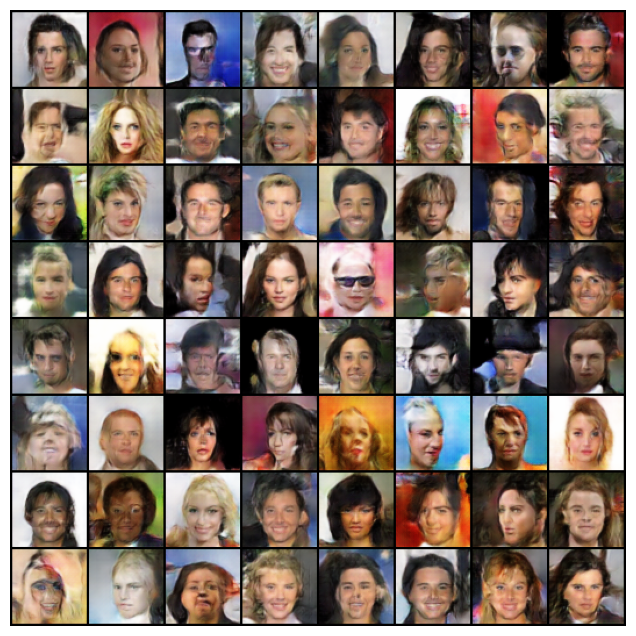

In [13]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())